In [1]:
# required to import local package

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
config = {
  "save_plots": False,
  "load_models": True,
}

In [3]:
import torch
from ogb.nodeproppred import PygNodePropPredDataset

# download dataset using ogb pytorch geometric loader.
dataset = PygNodePropPredDataset(name="ogbn-arxiv")

data = dataset[0] # pyg graph object

print(data)

Data(edge_index=[2, 1166243], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])


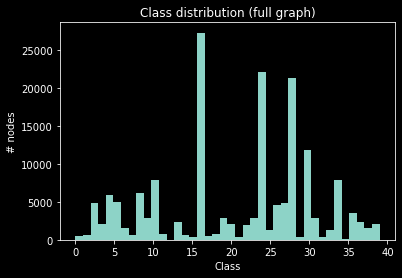

In [4]:
import matplotlib.pyplot as plt

plt.title("Class distribution (full graph)")
plt.hist(data.y.reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
if config["save_plots"] == True:
  plt.savefig("arxiv-class-dist.png")
plt.show()

graph is strongly connected component: False
graph is weakly connected component: True
graph has # weakly connected components: 1
graph has # isolated nodes: 0


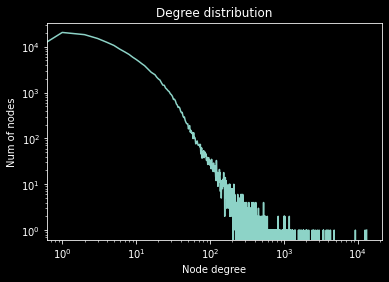

In [5]:
from lib import util

util.describe_graph(data, save_fig=config["save_plots"], log_scale=True)

## Split data set

year: 2010
year: 2015
year: 2020
graph sizes
year: 2010, # nodes: 12974, # edges: 21090


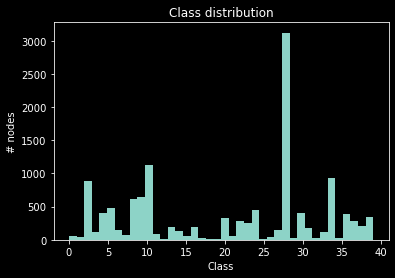

year: 2015, # nodes: 53160, # edges: 152226


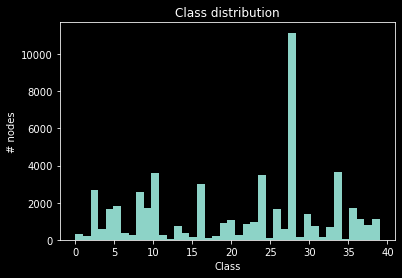

year: 2020, # nodes: 169343, # edges: 1166243


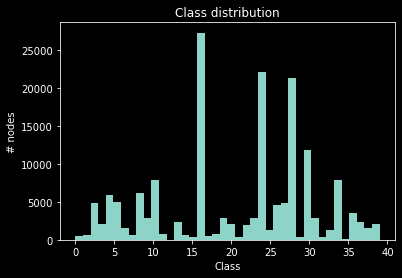

In [6]:
from lib.data import split_dataset, split

graphs = []

node_years = [2010,2015,2020]

for year in node_years:
  print("year: {}".format(year))
  indices = torch.nonzero(torch.where(data.node_year[:,0] <= year, 1, 0))[:,0].tolist()

  year_data = split(data, indices)

  # TODO: Retrieve test_indices only from current year
  train_data, calibration_indices, test_indices = split_dataset(year_data, test_frac=0.2, calibration_frac=0.2)
  graphs.append({
    "year": year,
    "data": year_data,
    "train_data": train_data,
    "calibration_indices": calibration_indices,
    "test_indices": test_indices,
  })

print("graph sizes")
for graph in graphs:
  print("year: {}, # nodes: {}, # edges: {}".format(graph["year"], graph["data"].x.shape[0], graph["data"].edge_index.shape[1]))
  plt.title("Class distribution")
  plt.hist(graph["data"].y.reshape(-1).detach().numpy(), dataset.num_classes)
  plt.xlabel("Class")
  plt.ylabel("# nodes")
  plt.show()

# GraphSAGE model

In [7]:
from lib.graphsage import GraphSAGE
from lib.evaluation import get_multiclass_classification_performance

from copy import deepcopy

args = {
    "num_layers": 3,
    "hidden_dim": 256,
    "lr": 0.01, # learning rate
    "epochs": 100,
}

models = {}
if config["load_models"] == True:
    for year in node_years:
        model = GraphSAGE(data.num_features, args["hidden_dim"], dataset.num_classes, args["num_layers"])
        # load checkpoint
        model.load_state_dict(torch.load("models/model_{}.pt".format(year))["model_state_dict"])
        models[year] = model
else:
    model = GraphSAGE(data.num_features, args["hidden_dim"], dataset.num_classes, args["num_layers"])

    # reset the parameters to initial random value
    model.reset_parameters()

    optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

    loss_fn = torch.nn.NLLLoss()

    models = {}
    for graph in graphs:
        print("training: {}".format(graph["year"]))
        for epoch in range(1, 1 + args["epochs"]):
            loss = model.train_model(graph["train_data"], optimizer, loss_fn)
        models[graph["year"]] = deepcopy(model)
        
        # save checkpoint
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
        }, "model_{}.pt".format(graph["year"]))


        y_hat = model.predict(graph["data"])
        y_hat = y_hat[graph["test_indices"]]
        y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)

        y_true = graph["data"].y[graph["test_indices"]].reshape(-1)

        acc, micro_f1 = get_multiclass_classification_performance(y_hat, y_true)

        print(f"Test acc: {100 * acc:.2f}%, "
            f"Test micro avg f1 score: {100 * micro_f1:.2f}%")

### Model performance per year

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out)
/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out)
/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torc

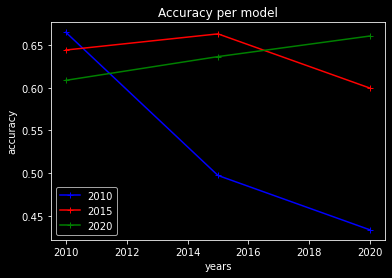

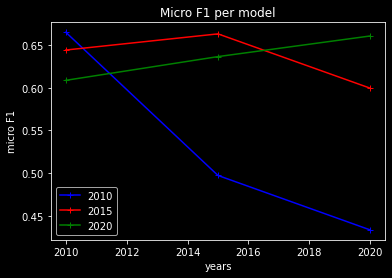

In [10]:
from lib.util import plot_multilines

years = node_years
accuracy_scores = []
micro_f1_scores = []
labels = []

for year, model in models.items():
  _accuracy_scores = []
  _micro_f1_scores = []

  for graph in graphs:
    graph_data = graph["data"]
    test_indices = graph["test_indices"]

    y_hat = model.predict(graph_data)
    y_hat = y_hat[test_indices]
    y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1).detach()

    y_true = graph_data.y[test_indices].reshape(-1).detach()

    acc, micro_f1 = get_multiclass_classification_performance(y_hat, y_true)
    _accuracy_scores.append(acc)
    _micro_f1_scores.append(micro_f1)
  
  accuracy_scores.append(_accuracy_scores)
  micro_f1_scores.append(_micro_f1_scores)
  labels.append(year)

plot_multilines("Accuracy per model", years, accuracy_scores, labels, "years", "accuracy", save_file=config["save_plots"])
plot_multilines("Micro F1 per model", years, micro_f1_scores, labels, "years", "micro F1", save_file=config["save_plots"])

### Performance per node (in-)degreee

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out)


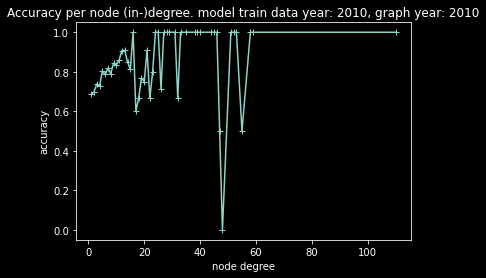

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out)


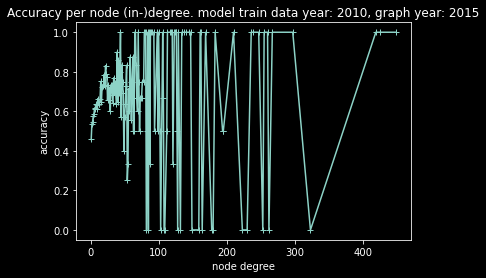

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out)


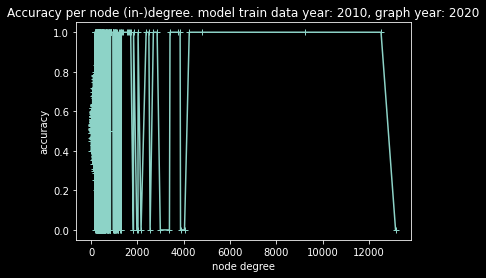

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out)


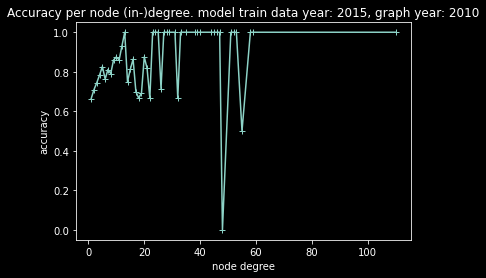

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out)


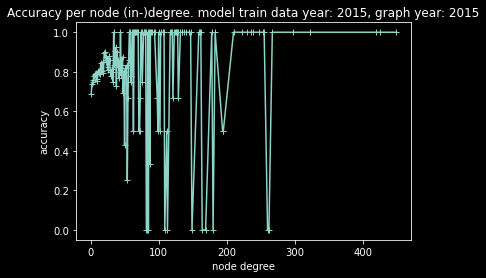

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out)


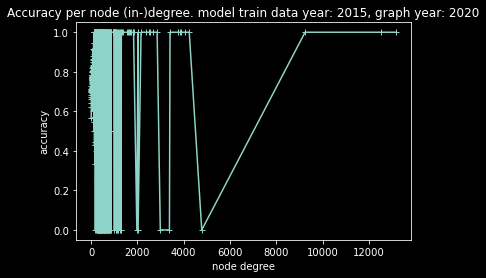

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out)


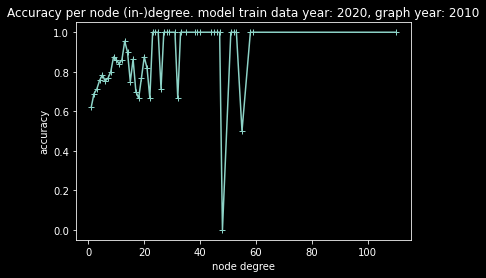

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out)


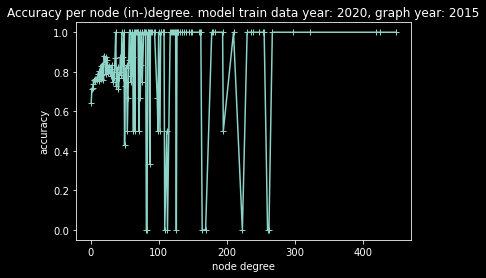

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out)


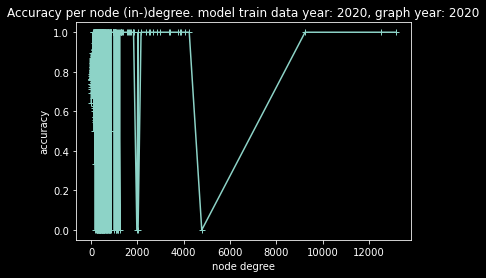

In [12]:
from lib.util import plot

for year, model in models.items():
  for graph in graphs:
    graph_data = graph["data"]
    test_indices = graph["test_indices"]

    y_hat = model.predict(graph_data)
    y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)
    y_true = graph_data.y.reshape(-1)

    node_idx, node_degree = torch.unique(graph_data.edge_index[1], return_counts=True)
    nd = torch.zeros(graph_data.x.shape[0]).long()
    nd[node_idx] = node_degree

    degrees = torch.unique(node_degree)

    degrees_with_samples = []
    accs = []
    for d in degrees:
      degree_mask = nd == d
      if y_hat[degree_mask].shape[0] > 0:
        acc, _ = get_multiclass_classification_performance(y_hat[degree_mask], y_true[degree_mask])

        degrees_with_samples.append(d)
        accs.append(acc)

    plot("Accuracy per node (in-)degree. model train data year: {}, graph year: {}".format(year, graph["year"]), degrees_with_samples, accs, "node degree", "accuracy", save_file=config["save_plots"])

# Inductive Conformal Classifier (without resampling)

In [9]:
from lib.conformal_predictor import InductiveConformalClassifier, get_nonconformity_measure_for_classification

cal_model = models[2010]
cal_data = graphs[0]["data"]
calibration_indices = graphs[0]["calibration_indices"]


cal_y_hat = cal_model.predict(cal_data)
cal_y_hat = cal_y_hat[calibration_indices]

y_true = cal_data.y[calibration_indices]
y_true = y_true.reshape(-1).detach()

cal_alphas = []
for y_probas, yt in zip(cal_y_hat,y_true):
  y = yt.item()
  alphas = get_nonconformity_measure_for_classification(y_probas)
  cal_alphas.append(alphas[y])

cal_alphas = torch.tensor(cal_alphas)

cp = InductiveConformalClassifier(cal_alphas)

TypeError: __init__() missing 1 required positional argument: 'y'

## coverage and efficiency

In [12]:
from lib.evaluation import get_coverage_and_efficiency

CONFIDENCE_LEVEL = 0.95

def get_confidence_intervals(cp, y_hat, confidence_level=0.95):
  confidence_intervals = []
  for yi in y_hat:
    alphas = get_nonconformity_measure_for_classification(yi)
    ci = cp.predict(alphas, confidence_level)
    confidence_intervals.append(ci)
  
  return confidence_intervals

### Overall

In [35]:
from tabulate import tabulate
from lib.util import print_percentage

years = node_years

for year, model in models.items():
  coverages = ["coverage"]
  avg_prediction_set_sizes = ["avg prediction set size"]
  frac_singleton_preds = ["frac singleton predictions"]
  frac_empty_preds = ["frac empty predictions"]

  for graph in graphs:
    graph_data = graph["data"]
    test_indices = graph["test_indices"]

    y_hat = model.predict(graph_data)
    y_hat = y_hat[test_indices].detach()

    y_true = graph_data.y[test_indices].reshape(-1).detach()

    confidence_intervals = get_confidence_intervals(cp, y_hat, CONFIDENCE_LEVEL)

    coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

    coverages.append(coverage)
    avg_prediction_set_sizes.append(avg_prediction_set_size)
    frac_singleton_preds.append(frac_singleton_pred)
    frac_empty_preds.append(frac_empty_pred)
  
  scores = [coverages, avg_prediction_set_sizes, frac_singleton_preds, frac_empty_preds]

  print_percentage("ICC perf. model year: {} with Confidence level".format(year), CONFIDENCE_LEVEL)
  print(tabulate(scores, headers=years))

ICC perf. model year: 2010 with Confidence level: 95.00%
                                2010      2015       2020
--------------------------  --------  --------  ---------
coverage                    0.945258  0.849323  0.815844
avg prediction set size     5.34811   5.70598   5.82937
frac singleton predictions  0.193909  0.137133  0.0877525
frac empty predictions      0         0         0
ICC perf. model year: 2015 with Confidence level: 95.00%
                                2010       2015       2020
--------------------------  --------  ---------  ---------
coverage                    0.967618  0.96661    0.945553
avg prediction set size     6.76291   6.34133    6.59106
frac singleton predictions  0.10717   0.0987585  0.0636884
frac empty predictions      0         0          0
ICC perf. model year: 2020 with Confidence level: 95.00%
                                 2010       2015       2020
--------------------------  ---------  ---------  ---------
coverage                    0

# Mondrian Conformal Prediction (MCP) without resampling

In [10]:
from lib.conformal_predictor import MondrianConformalClassifier

cal_model = models[2010]
cal_data = graphs[0]["data"]
calibration_indices = graphs[0]["calibration_indices"]

cal_y_hat = cal_model.predict(cal_data)
cal_y_hat = cal_y_hat[calibration_indices]

y_true = cal_data.y[calibration_indices]
y_true = y_true.reshape(-1).detach()

cal_alphas = []
for y_probas, yt in zip(cal_y_hat,y_true):
  y = yt.item()
  alphas = get_nonconformity_measure_for_classification(y_probas)
  cal_alphas.append(alphas[y])

cal_alphas = torch.tensor(cal_alphas)
cal_y = y_true

mcp = MondrianConformalClassifier(cal_alphas, cal_y)

## Performance
### Overall

In [13]:
years = node_years

for year, model in models.items():
  coverages = ["coverage"]
  avg_prediction_set_sizes = ["avg prediction set size"]
  frac_singleton_preds = ["frac singleton predictions"]
  frac_empty_preds = ["frac empty predictions"]

  for graph in graphs:
    graph_data = graph["data"]
    test_indices = graph["test_indices"]

    y_hat = model.predict(graph_data)
    y_hat = y_hat[test_indices].detach()

    y_true = graph_data.y[test_indices].reshape(-1).detach()

    confidence_intervals = get_confidence_intervals(mcp, y_hat, CONFIDENCE_LEVEL)

    coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

    coverages.append(coverage)
    avg_prediction_set_sizes.append(avg_prediction_set_size)
    frac_singleton_preds.append(frac_singleton_pred)
    frac_empty_preds.append(frac_empty_pred)
  
  scores = [coverages, avg_prediction_set_sizes, frac_singleton_preds, frac_empty_preds]

  print_percentage("MCP perf. model year: {} with Confidence level".format(year), CONFIDENCE_LEVEL)
  print(tabulate(scores, headers=years))

MCP perf. model year: 2010 with Confidence level: 95.00%
                                  2010        2015        2020
--------------------------  ----------  ----------  ----------
coverage                     0.966076    0.91582     0.897248
avg prediction set size     11.9715     12.487      12.7707
frac singleton predictions   0.0986893   0.0575621   0.0349002
frac empty predictions       0           0           0
MCP perf. model year: 2015 with Confidence level: 95.00%
                                 2010       2015        2020
--------------------------  ---------  ---------  ----------
coverage                     0.97687    0.977427   0.963387
avg prediction set size     19.8092    19.0454    21.0725
frac singleton predictions   0.106014   0.092927   0.0470651
frac empty predictions       0          0          0
MCP perf. model year: 2020 with Confidence level: 95.00%
                                 2010        2015        2020
--------------------------  ---------  --------

# standard MCP (node (in-)degree based)

In [ ]:
BINS = torch.tensor([0,1,2]) # boundaries[i-1] < input[x] <= boundaries[i]

# get node degrees
c_node_ids, c_node_degrees = torch.unique(data.edge_index[1], return_counts=True)
cal_node_degrees = torch.zeros(data.x.shape[0]).long()
cal_node_degrees[c_node_ids] = c_node_degrees

cal_node_degrees = cal_node_degrees[calibration_indices] # only use calibration nodes


c_node_degrees_bins = torch.bucketize(cal_node_degrees, BINS)

calibration_taxonomy = c_node_degrees_bins

mcp_node_degree = ConformalClassifier(cal_alphas, cal_y, True, calibration_taxonomy, False)

## Performance

### Overall

Confidence level: 95.00%
Coverage: 95.56%
Avg prediction set size: 1.89
Singleton predictions: 54.90%
Empty predictions: 0.00%


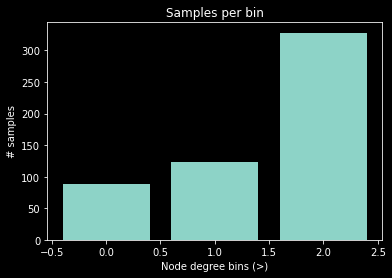

In [ ]:
nd_bins = torch.bucketize(nd, BINS)

degrees = torch.unique(nd_bins)

coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
samples_per_bin = []

for d in degrees:
  degree_mask = nd_bins == d
  
  confidence_intervals = get_confidence_intervals(mcp_node_degree, y_hat[degree_mask], CONFIDENCE_LEVEL, d)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  samples_per_bin.append(y_true[degree_mask].shape[0])
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

dataset_size = torch.sum(torch.tensor(samples_per_bin))
avg_coverage = torch.sum(torch.tensor(coverages) * torch.tensor(samples_per_bin) / dataset_size)
avg_prediction_set_size = torch.sum(torch.tensor(avg_prediction_set_sizes) * torch.tensor(samples_per_bin) / dataset_size) 
avg_frac_singleton_pred = torch.sum(torch.tensor(frac_singleton_preds) * torch.tensor(samples_per_bin) / dataset_size) 
avg_frac_empty_pred = torch.sum(torch.tensor(frac_empty_preds) * torch.tensor(samples_per_bin) / dataset_size) 

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(avg_coverage, avg_prediction_set_size, avg_frac_singleton_pred, avg_frac_empty_pred)

plot_bar("Samples per bin", BINS, samples_per_bin, "Node degree bins (>)", "# samples", True)

### Performance per node degree bucket

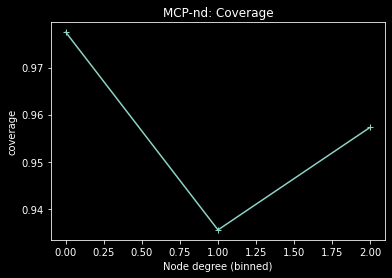

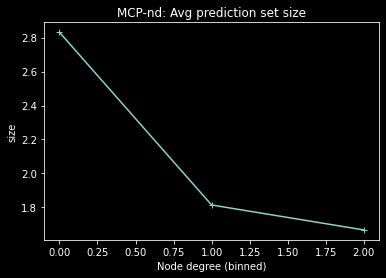

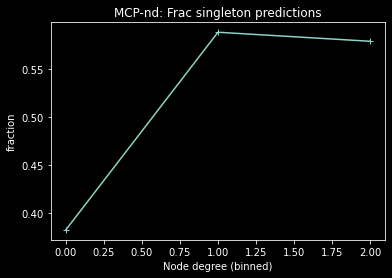

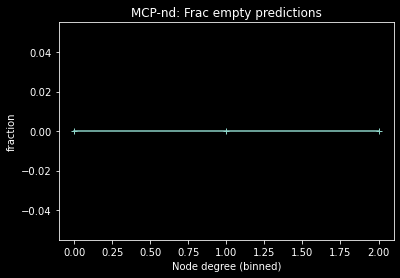

In [ ]:
save_plot = True
x_label = "Node degree (binned)"
plot("MCP-nd: Coverage", BINS, coverages, x_label, "coverage", save_plot)
plot("MCP-nd: Avg prediction set size", BINS, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("MCP-nd: Frac singleton predictions", BINS, frac_singleton_preds, x_label, "fraction", save_plot)
plot("MCP-nd: Frac empty predictions", BINS, frac_empty_preds, x_label, "fraction", save_plot)

### Performance per class

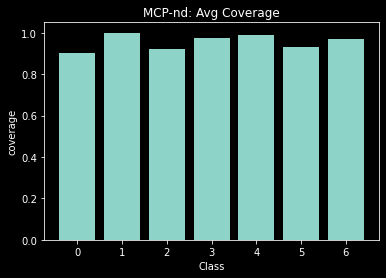

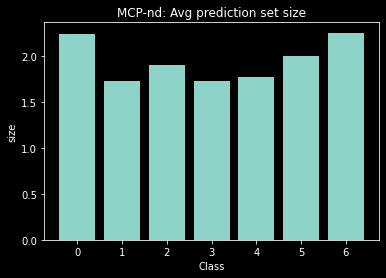

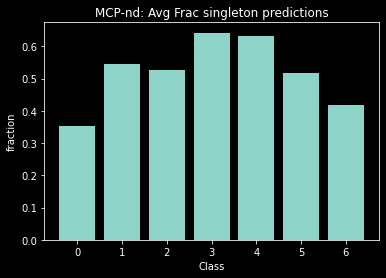

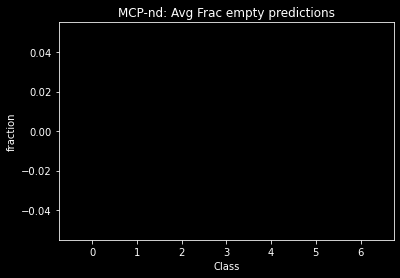

In [ ]:
avg_coverages = []
avg_prediction_set_sizes = []
avg_frac_singleton_preds = []
avg_frac_empty_preds = []
for c in range(dataset.num_classes):
  coverages = []
  prediction_set_sizes = []
  frac_singleton_preds = []
  frac_empty_preds = []
  samples_per_bin = []
  for d in degrees:
    degree_class_mask = torch.logical_and(nd_bins == d, y_true == c)

    confidence_intervals = get_confidence_intervals(mcp_node_degree, y_hat[degree_class_mask], CONFIDENCE_LEVEL, d)
    
    coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_class_mask])

    samples_per_bin.append(y_true[degree_class_mask].shape[0])
    coverages.append(coverage)
    prediction_set_sizes.append(avg_prediction_set_size)
    frac_singleton_preds.append(frac_singleton_pred)
    frac_empty_preds.append(frac_empty_pred)
  
  dataset_size = torch.sum(torch.tensor(samples_per_bin))
  avg_coverage = torch.sum(torch.tensor(coverages) * torch.tensor(samples_per_bin) / dataset_size)
  avg_prediction_set_size = torch.sum(torch.tensor(prediction_set_sizes) * torch.tensor(samples_per_bin) / dataset_size)
  avg_frac_singleton_pred = torch.sum(torch.tensor(frac_singleton_preds) * torch.tensor(samples_per_bin) / dataset_size)
  avg_frac_empty_pred = torch.sum(torch.tensor(frac_empty_preds) * torch.tensor(samples_per_bin) / dataset_size)
  
  avg_coverages.append(avg_coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  avg_frac_singleton_preds.append(avg_frac_singleton_pred)
  avg_frac_empty_preds.append(avg_frac_empty_pred)

save_plot = True
x_label = "Class"
classes = range(dataset.num_classes)
plot_bar("MCP-nd: Avg Coverage", classes, avg_coverages, x_label, "coverage", save_plot)
plot_bar("MCP-nd: Avg prediction set size", classes, avg_prediction_set_sizes, x_label, "size", save_plot)
plot_bar("MCP-nd: Avg Frac singleton predictions", classes, avg_frac_singleton_preds, x_label, "fraction", save_plot)
plot_bar("MCP-nd: Avg Frac empty predictions", classes, avg_frac_empty_preds, x_label, "fraction", save_plot)

# Cumulative MCP (node (in-)degree based)

In [ ]:
BINS = torch.tensor([0,1,2,3,4,5,6,7,8,9,10]) # boundaries[i-1] < input[x] <= boundaries[i]

# get node degrees
c_node_ids, c_node_degrees = torch.unique(data.edge_index[1], return_counts=True)
cal_node_degrees = torch.zeros(data.x.shape[0]).long()
cal_node_degrees[c_node_ids] = c_node_degrees

cal_node_degrees = cal_node_degrees[calibration_indices] # only use calibration nodes


c_node_degrees_bins = torch.bucketize(cal_node_degrees, BINS)

calibration_taxonomy = c_node_degrees_bins

mcp_node_degree = ConformalClassifier(cal_alphas, cal_y, True, calibration_taxonomy, True)

## Performance

### Overall

Confidence level: 95.00%
Coverage: 95.36%
Avg prediction set size: 1.96
Singleton predictions: 57.18%
Empty predictions: 0.00%


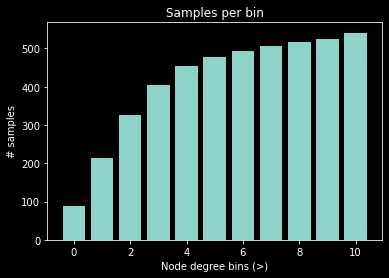

In [ ]:
nd_bins = torch.bucketize(nd, BINS)

degrees = torch.unique(nd_bins)

coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
samples_per_bin = []

for d in degrees:
  degree_mask = nd_bins <= d
  
  confidence_intervals = get_confidence_intervals(mcp_node_degree, y_hat[degree_mask], CONFIDENCE_LEVEL, d)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  samples_per_bin.append(y_true[degree_mask].shape[0])
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

dataset_size = torch.sum(torch.tensor(samples_per_bin))
avg_coverage = torch.sum(torch.tensor(coverages) * torch.tensor(samples_per_bin) / dataset_size)
avg_prediction_set_size = torch.sum(torch.tensor(avg_prediction_set_sizes) * torch.tensor(samples_per_bin) / dataset_size) 
avg_frac_singleton_pred = torch.sum(torch.tensor(frac_singleton_preds) * torch.tensor(samples_per_bin) / dataset_size) 
avg_frac_empty_pred = torch.sum(torch.tensor(frac_empty_preds) * torch.tensor(samples_per_bin) / dataset_size) 

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(avg_coverage, avg_prediction_set_size, avg_frac_singleton_pred, avg_frac_empty_pred)

plot_bar("Samples per bin", BINS, samples_per_bin, "Node degree bins (>)", "# samples", True)

### Performance per node degree bucket

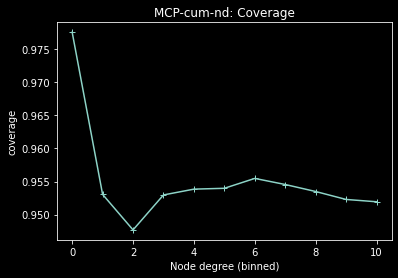

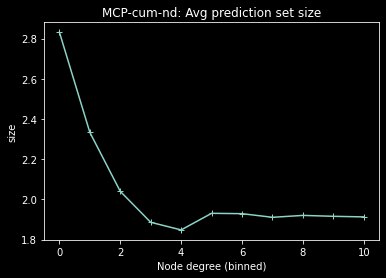

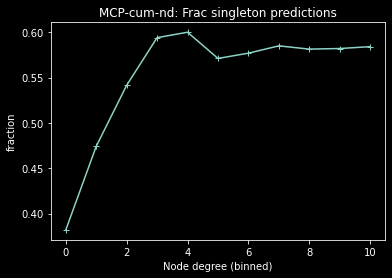

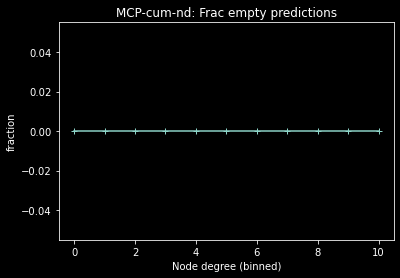

In [ ]:
save_plot = True
x_label = "Node degree (binned)"
plot("MCP-cum-nd: Coverage", BINS, coverages, x_label, "coverage", save_plot)
plot("MCP-cum-nd: Avg prediction set size", BINS, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("MCP-cum-nd: Frac singleton predictions", BINS, frac_singleton_preds, x_label, "fraction", save_plot)
plot("MCP-cum-nd: Frac empty predictions", BINS, frac_empty_preds, x_label, "fraction", save_plot)

# Cumulative MCP (class-based)

In [ ]:
mcp_class_cum = ConformalClassifier(cal_alphas, cal_y, True, cal_y, True)

In [ ]:
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
samples_per_class = []
for c in range(dataset.num_classes):
  class_mask = y_true <= c

  confidence_intervals = get_confidence_intervals(mcp_class_cum, y_hat[class_mask], CONFIDENCE_LEVEL, c)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[class_mask])

  samples_per_class.append(y_true[class_mask].shape[0])
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

dataset_size = torch.sum(torch.tensor(samples_per_class))
avg_coverage = torch.sum(torch.tensor(coverages) * torch.tensor(samples_per_class) / dataset_size)
avg_prediction_set_size = torch.sum(torch.tensor(avg_prediction_set_sizes) * torch.tensor(samples_per_class) / dataset_size) 
avg_frac_singleton_pred = torch.sum(torch.tensor(frac_singleton_preds) * torch.tensor(samples_per_class) / dataset_size) 
avg_frac_empty_pred = torch.sum(torch.tensor(frac_empty_preds) * torch.tensor(samples_per_class) / dataset_size) 

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(avg_coverage, avg_prediction_set_size, avg_frac_singleton_pred, avg_frac_empty_pred)


Confidence level: 95.00%
Coverage: 95.01%
Avg prediction set size: 1.62
Singleton predictions: 61.82%
Empty predictions: 0.57%


# Weighted Conformal Prediction

Inspired by "Conformal prediction beyond exchangeability" (2022)

In [ ]:
class DegreeWeightedConformalClassifier():
  """
  Inductive conformal prediction based on "Tutorial On Conformal Prediction" by Shafer & Vovk (p. 388).
  Extended with Mondrian Conformal Prediction option based on "Mondrian Conformal Regressors" by Boström & Johansson, and https://gist.github.com/dsleo/2880882b5e1c1feab677c4cf421e806d
  """
  def __init__(self, alphas, y, degrees):
    """
    alphas: non-conformity measures (n_samples).
    y: targets (n_samples)
    mondrian_taxonomy: the samples categories (n_samples)
    """
    super()

    self.alphas = alphas
    self.y = y
    self.degrees = degrees

    return
  
  def predict(self, alphas, degree, confidence_level):
    """
    Retrieve a prediction region for the provided nonconformity measures 
    \nOBS! Only single samples allowed
    \nconfidence_level: e.g. 0.99
    """

    significance_level = 1 - confidence_level

    prediction_region = []

    classes = torch.unique(self.y)
    
    # weights
    max_degree = torch.max(torch.cat((self.degrees, torch.tensor([degree]))))
    normalized_degrees = self.degrees / max_degree
    weights = 1 - torch.abs((degree/max_degree) - normalized_degrees)
    sum_weights = torch.sum(weights) + 1
    normalized_weights = weights / sum_weights
    normalized_weight = 1 / sum_weights

    for y in classes:
      ai = alphas[y] * normalized_weight

      # non-conformity scores
      a = self.alphas * normalized_weights
      
      # calculate p-score
      c = torch.count_nonzero(a >= ai)
      p_score = c / len(a)

      if p_score > significance_level:
        prediction_region.append(y)
    # END: for
      
    return prediction_region

In [ ]:
node_idx, node_degree = torch.unique(data.edge_index[1], return_counts=True)
nd = torch.zeros(data.x.shape[0]).long()
nd[node_idx] = node_degree
# only keep test indices
cal_nd = nd[calibration_indices]

cp = DegreeWeightedConformalClassifier(cal_alphas, cal_y, cal_nd)

def get_confidence_intervals_weighted(cp, y_hat, degrees, confidence_level=0.95):
  confidence_intervals = []
  for yi, d in zip(y_hat,degrees):
    alphas = get_nonconformity_measure_for_classification(yi, version="v2")
    ci = cp.predict(alphas, d, confidence_level)
    confidence_intervals.append(ci)
  
  return confidence_intervals

test_nd = nd[test_indices]
confidence_intervals = get_confidence_intervals_weighted(cp, y_hat, test_nd, CONFIDENCE_LEVEL)

coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)

Confidence level: 95.00%
Coverage: 93.53%
Avg prediction set size: 1.35
Singleton predictions: 77.45%
Empty predictions: 0.00%
